In [52]:
import io
import random
import itertools
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

logdir = "runs/exp"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
file_writer_imgs = tf.summary.create_file_writer(logdir + '/imgs')

In [53]:
import sys

sys.path.append("../")
from scripts.model import create_model, train_model

# Training with logging

In [54]:
train = pd.read_csv("../data/d1.csv")
test = pd.read_csv("../data/mnist_test.csv")

X_train = train.iloc[:, 1:].values / 255.0
X_test = test.iloc[:, 1:].values / 255.0
y_train = train["label"].values
y_test = test["label"].values

learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

model = create_model(learning_rate)

In [62]:
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image


def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure


def plot_images(data: list[tuple[np.ndarray, int, int]], show_labels=False, title="", figsize=(5,2)):
    figure = plt.figure(figsize=figsize)
    while len(data) % 5 != 0:
        data.append((np.zeros_like(data[0][0]), ""))
    for i, (x, y_pred, y_true) in enumerate(data):
        ax = plt.subplot(len(data) // 5, 5, i+1)
        if show_labels:
            ax.set_title(f"p:{y_pred} gt:{y_true}")
        ax.imshow(x)
        ax.axis('off')
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    return figure


def log_test_results(epoch, logs):
  if epoch % 10 == 0:
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(X_test)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Log the confusion matrix.
    cm = confusion_matrix(y_test, test_pred)
    figure = plot_confusion_matrix(cm, class_names=np.unique(y_test))
    cm_image = plot_to_image(figure)
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

    # Log bad predictions
    some_bad_imgs = []
    labels = []
    pred_labels = []
    for label in range(10):
        df = test[(test.label == label) & (test.label != test_pred)]
        bad_predicts = df.iloc[:, 1:].values.reshape(-1, 28, 28)
        pred_labels += list(test_pred[(test.label == label) & (test.label != test_pred)])[-5:]
        some_bad_imgs.append(bad_predicts[-5:])
        labels.extend([label]*5)
    some_bad_imgs = np.concatenate(some_bad_imgs)
    bad_imgs_fig = plot_images(list(zip(some_bad_imgs, pred_labels, labels)), figsize=(8, 6), show_labels=True)
    bad_imgs_fig = plot_to_image(bad_imgs_fig)
    with file_writer_imgs.as_default():
        tf.summary.image("Bad predicts", bad_imgs_fig, step=epoch)


prediction_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_test_results)

In [56]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    validation_split=validation_split,
    callbacks=[tensorboard_callback, prediction_callback]
)
h_epochs = history.epoch
hist = pd.DataFrame(history.history)

Epoch 1/50
12/12 [==============================] - 2s 129ms/step - loss: 2.1978 - accuracy: 0.2581 - val_loss: 1.9658 - val_accuracy: 0.4731
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 1.8334 - accuracy: 0.4701 - val_loss: 1.5941 - val_accuracy: 0.5990
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 1.5252 - accuracy: 0.5683 - val_loss: 1.2998 - val_accuracy: 0.6887
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 1.2945 - accuracy: 0.6400 - val_loss: 1.0788 - val_accuracy: 0.7534
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 1.1203 - accuracy: 0.6914 - val_loss: 0.9097 - val_accuracy: 0.8083
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.9866 - accuracy: 0.7362 - val_loss: 0.7779 - val_accuracy: 0.8397
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.8808 - accuracy: 0.7606 - val_loss: 0.6795 - val_accuracy: 0.8549
Epoch 8/50
12/12 [

# Model analysis

In [6]:
model = tf.keras.saving.load_model("../checkpoint/")

In [57]:
def plot_img(img, figsize=(2, 2)):
    figure = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def get_cutout_imgs(img, ks=(2,2), s=2, c=0):
    result_imgs = []
    for i in range(0, img.shape[0] // s + 1):
        for j in range(0, img.shape[1] // s + 1):
            res_img = img.copy()
            res_img[i*s:i*s+ks[0], j*s:j*s+ks[1]] = c
            result_imgs.append(res_img)
    return result_imgs

img = test.iloc[0, 1:].values.reshape((28, 28))
cutout_imgs = get_cutout_imgs(img, (7, 7), 7)
len(cutout_imgs)

25

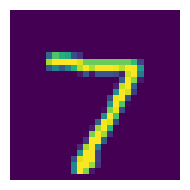

1/1 [==============================] - 0s 14ms/step
[[2.8403368e-04 3.7575235e-06 1.5929085e-03 8.6321525e-04 1.8865982e-04
  2.0325984e-05 2.9322848e-06 9.9567044e-01 2.4889408e-05 1.3488163e-03]]


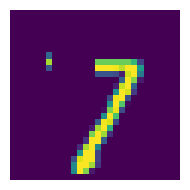

1/1 [==============================] - 0s 15ms/step
[[1.09231914e-03 1.09083681e-04 2.94314534e-03 5.74664818e-03
  2.40512332e-03 8.41431465e-05 2.06924615e-05 9.74316180e-01
  6.32392112e-05 1.32193575e-02]]


In [58]:
img = test.iloc[0, 1:].values.reshape((28, 28))
plot_img(img)
print(model.predict(img.flatten()[None] / 255))
plot_img(cutout_imgs[6])
print(model.predict(cutout_imgs[6].flatten()[None] / 255))

In [46]:
kernel_size = (4, 4)
stride = 1

base_predicts = model.predict(test.iloc[:, 1:].values / 255, verbose=False)

# too slow
importance_maps = []
for idx in tqdm(range(len(test))):
    img = test.iloc[idx, 1:].values.reshape((28, 28))
    true_label = test.iloc[idx, 0]
    base_pred = base_predicts[idx][true_label]

    cutout_imgs = get_cutout_imgs(img, kernel_size, stride)
    cutout_imgs = np.stack(cutout_imgs)
    cutout_preds = model.predict(cutout_imgs.reshape((-1, 28 * 28)) / 255, verbose=False)[:, true_label].reshape(-1)
    importance_map = np.abs(base_pred - cutout_preds)
    importance_map = importance_map.reshape(int(len(importance_map) ** 0.5), int(len(importance_map) ** 0.5))

    importance_maps.append(importance_map)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
all_cutout_images = []
for idx in tqdm(range(len(test))):
    img = test.iloc[idx, 1:].values.reshape((28, 28))
    cutout_imgs = get_cutout_imgs(img, kernel_size, stride)
    cutout_imgs = np.stack(cutout_imgs)
    all_cutout_images.append(cutout_imgs)

In [15]:
all_cutout_images = np.concatenate(all_cutout_images)

In [16]:
cutout_preds = model.predict(all_cutout_images.reshape((-1, 28 * 28)) / 255, verbose=False)

In [27]:
importance_maps = []
for idx in tqdm(range(len(test))):
    true_label = test.iloc[idx, 0]
    base_pred = base_predicts[idx][true_label]

    cut_p = cutout_preds[len(cutout_imgs)*idx:len(cutout_imgs)*(idx+1), true_label].reshape(-1)
    importance_map = np.abs(base_pred - cut_p)
    importance_map = importance_map.reshape((int(len(importance_map) ** 0.5), int(len(importance_map) ** 0.5)))

    importance_maps.append(importance_map)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
importance_maps = np.stack(importance_maps)

In [49]:
np.savez_compressed("imp_maps.npz", maps=importance_maps)

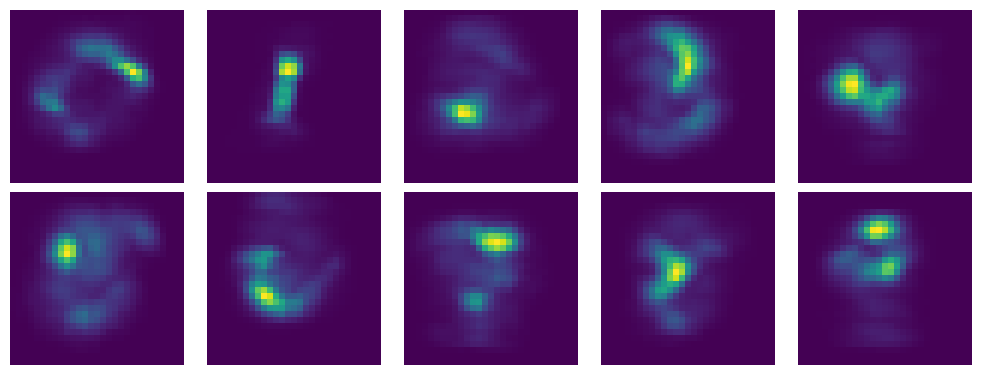

In [64]:
imp_mean_imgs = []
for lbl in range(10):
    imp_mean_imgs.append(importance_maps[test.label == lbl].mean(0))

fig = plot_images(list(zip(imp_mean_imgs, [-1]*10, [-1]*10)), figsize=(10, 4))

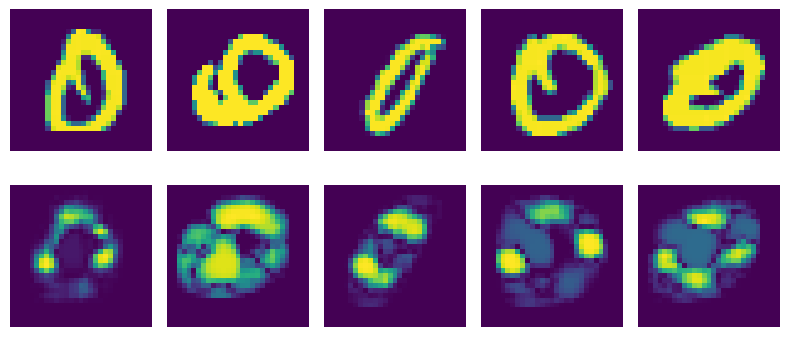

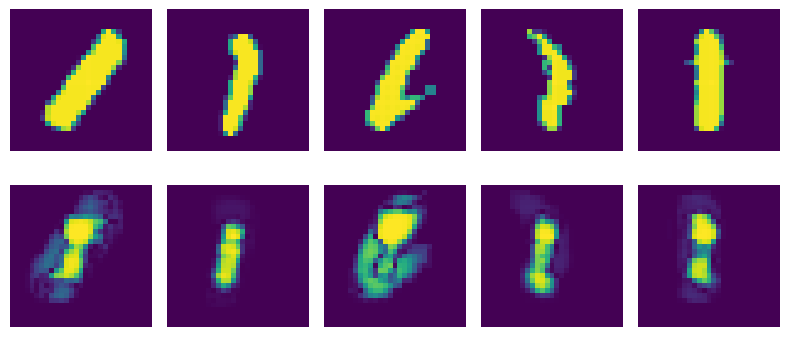

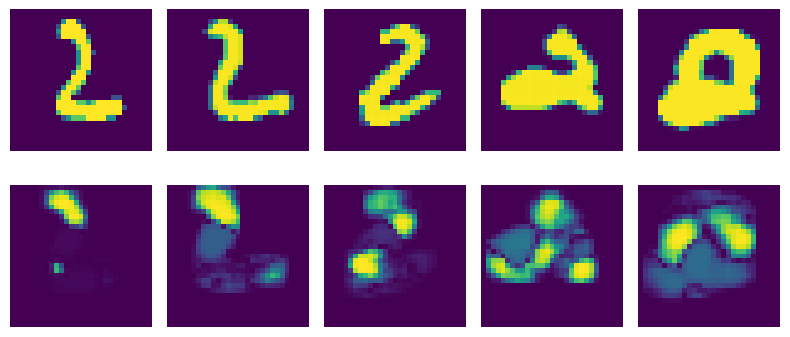

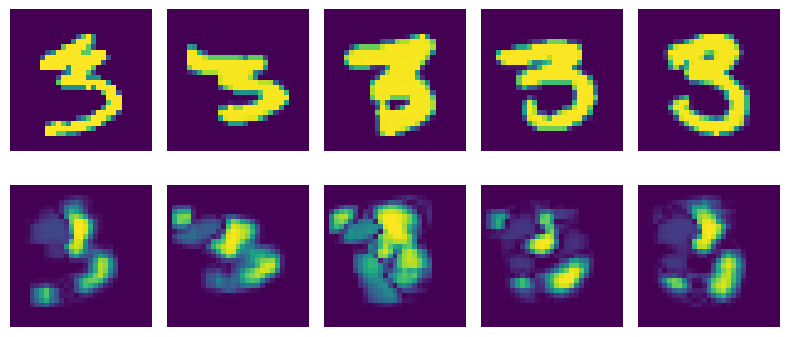

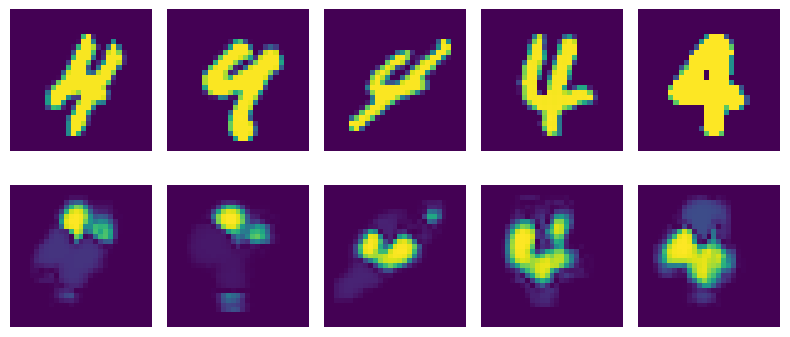

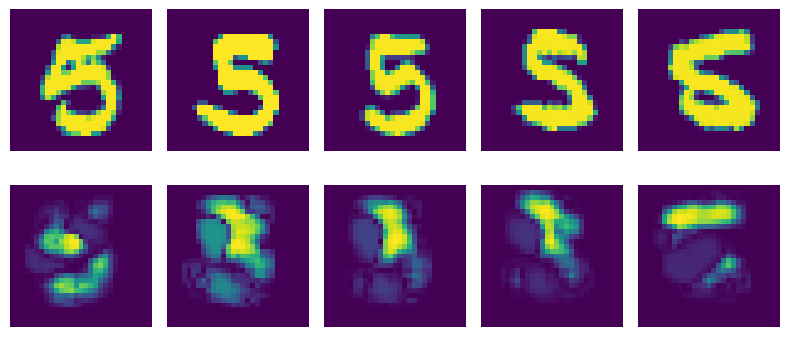

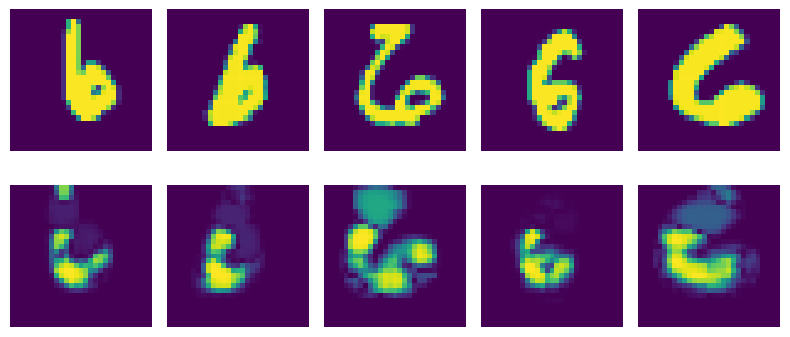

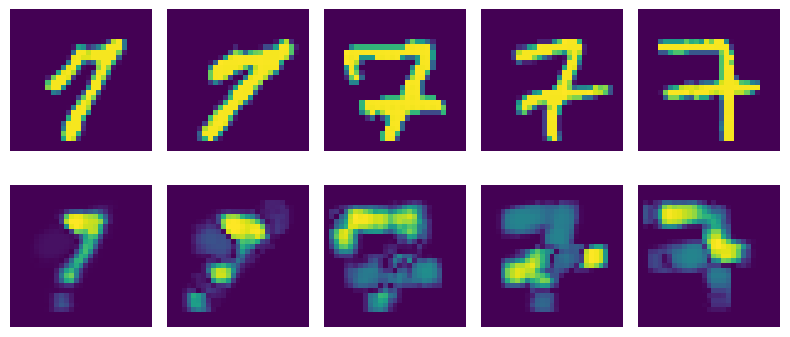

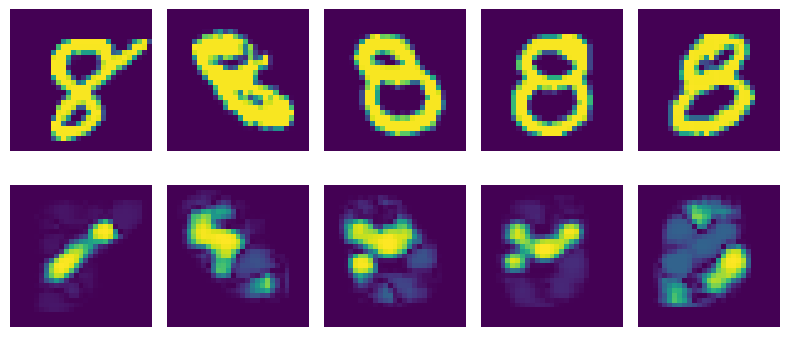

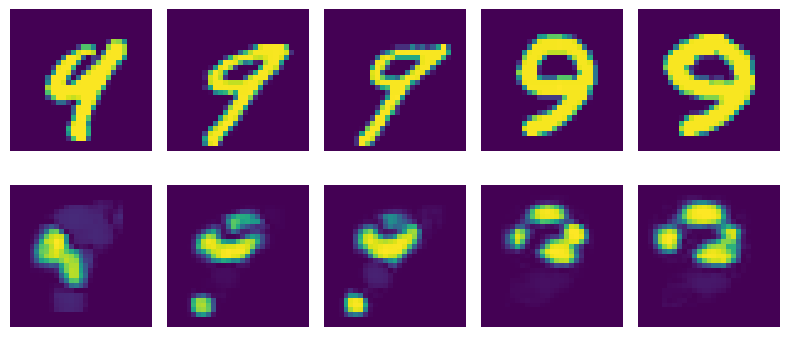

In [86]:
for lbl in range(10):
    cur_label_imp_maps = importance_maps[test.label == lbl]
    mean_imp_img = cur_label_imp_maps.mean(0)

    cur_imgs = list(zip(test[test.label == lbl].iloc[:, 1:].values.reshape(-1, 28, 28), cur_label_imp_maps))

    top_outliers = sorted(
        cur_imgs, key=lambda x: np.mean((mean_imp_img - x[1]) ** 2)
    )[-5:]
    
    figure = plt.figure(figsize=(8, 4))
    for i, (img, imp_matrix) in enumerate(top_outliers):
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax = plt.subplot(2, 5, i+1+5)
        ax.imshow(imp_matrix)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
